<h1><center>Rapport Neo4j / Cypher</h1></center>
<p><center> Quentin BETTE et Geoffrey HARRAZI</p></center>
<p><center>25/11/2020<p></center>
<img src="img/neo4j_logo.png" alt="Drawing" style="width: 200px;"/>
<img src="img/utt_logo.png" alt="Drawing" style="width: 200px;"/>

<p>Nous avons décidé d'utiliser les données météo publiques issues des messages internationaux d’observation en surface (SYNOP) circulant sur le système mondial de télécommunication (SMT) de l’Organisation Météorologique Mondiale (OMM). Nous voulons utiliser la puissance des systèmes de gestion de base de données en graphe et du language Cypher pour requeter des informations météorologiques.

Pour chacune des 62 stations, il y a un relevé toutes les 3h des données météorologiques</p>
<p>Données:</p> 
<p>Météo:<a>https://donneespubliques.meteofrance.fr/?fond=produit&id_produit=90&id_rubrique=32</a></p>
<p>Informations stations:<a>https://donneespubliques.meteofrance.fr/donnees_libres/Txt/Synop/postesSynop.csv</a></p> 
<p>Informations Commune 2020:<a>https://www.insee.fr/fr/information/4316069</a></p> 
<p>Population 2017: Fait à la main (fourni)</p> 


<p>Documentation: </p> <a>https://donneespubliques.meteofrance.fr/client/document/doc_parametres_synop_168.pdf</a>

<img src="img/Documentation Paramètres SYNOP.png"/>

<b>Dans un premier temps il faut créer une base de données vide et locale Neo4j en version 4.1.3 avec:
    
    user = neo4j
   
    password =  "admin"

Changez les valeurs suivante dans votre fichier conf/neo4j.conf:

dbms.memory.heap.initial_size=1G 

dbms.memory.heap.max_size=2G

Puis lancer la base de données

<h1>Import et variables globales</h1>

In [1]:
from neo4j import GraphDatabase
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import glob
from io import StringIO
import os
import shutil
import zipfile

uri = "bolt://localhost:7687"
user  = "neo4j"
password = "admin"
#A REMPLACER PR VOTRE DOSSIER D'IMPORT NEO4J
import_directory = "C:/Users/geoff/AppData/Local/Neo4j/Relate/Data/dbmss/dbms-86bb3107-5e46-4227-a52a-85c1bb52f5ef/import"


<h1>Téléchargement des données</h1>

Téléchargement des fichiers mois par mois depuis donneespubliques.meteofrance.fr

On télécharge (quand disponible) les relevés des stations du 01/1990 jusqu'au 10/2020.
Ensuite, on les fusionne dans un fichier csv merged_data de + 1gb

In [2]:
def download_all_data(start_year, end_year):
    """Downloading all meteo data files from start_year to end_year"""
    years = range(start_year, end_year+1)
    months = range(1, 13)
    for year in years:
        for month in months:
            date = str(year)+str(month).zfill(2)
            url = "https://donneespubliques.meteofrance.fr/donnees_libres/Txt/Synop/Archive/synop."+date+".csv.gz"
            r = requests.get(url, allow_redirects=True)            
            if "DOCTYPE HTML" not in str(r.content):
                f = open("data/synop/"+date+".csv", 'wb').write(r.content)
                print(date)
                #print(r.content)
               
 

def merge_csv(directory):
    """Merging all CSV files in directory"""
    interesting_files = glob.glob(directory+"*.csv")
    #print(interesting_files)
    df = pd.concat((pd.read_csv(f, header=0) for f in interesting_files))
    df.to_csv("data/merged_data.csv", index=False)


In [3]:
#On lance les téléchargements
#Cette opération peut durer plusieurs minutes
download_all_data(1995, 2020)

199601
199602
199603
199604
199605
199606
199607
199608
199609
199610
199611
199612
199701
199702
199703
199704
199705
199706
199707
199708
199709
199710
199711
199712
199801
199802
199803
199804
199805
199806
199807
199808
199809
199810
199811
199812
199901
199902
199903
199904
199905
199906
199907
199908
199909
199910
199911
199912
200001
200002
200003
200004
200005
200006
200007
200008
200009
200010
200011
200012
200101
200102
200103
200104
200105
200106
200107
200108
200109
200110
200111
200112
200201
200202
200203
200204
200205
200206
200207
200208
200209
200210
200211
200212
200301
200302
200303
200304
200305
200306
200307
200308
200309
200310
200311
200312
200401
200402
200403
200404
200405
200406
200407
200408
200409
200410
200411
200412
200501
200502
200503
200504
200505
200506
200507
200508
200509
200510
200511
200512
200601
200602
200603
200604
200605
200606
200607
200608
200609
200610
200611
200612
200701
200702
200703
200704
200705
200706
200707
200708
200709
200710
200711

In [4]:
#On merge les fichiers csv en un
#Cette opération peut durer 2mn
merge_csv("data/synop/")

<h2>Deplacer le fichier  vers le repertoir d'import</h2>

In [5]:
#On déplace le fichier merged_data.csv vers le dossier d'import de notre projet Neo4j
shutil.move('data/merged_data.csv', import_directory)

'C:/Users/geoff/AppData/Local/Neo4j/Relate/Data/dbmss/dbms-86bb3107-5e46-4227-a52a-85c1bb52f5ef/import\\merged_data.csv'

<h1>Import dans la Base de donnée</h1>

<h2>Modèle:</h2>
<p>Le noeud relevé contient les informations météorologiques.
Chaque relevé possède 4 relations pour modéliser l'année, le mois, le jour et l'heure du relevé. Il y a également une relation entre le relevé et un noeud station qui contient des informations de locatlisation de la station et les infos sur la ville où la station est implentée.</p>

<p>Interet d'une base de données en graphe ?</p>
<p> L'intêret est de pouvoir effectuer des requêtes lourdes en aggrégation afin d'avoir des résultats et des données à travers l'ensemble des stations et sur 25 ans. Cela facilite les aggregations par mois, heures, année ce qui peut-être très utile dans le cadre d'analyse météo comparative</p>

<img src="img/arrows.svg" alt="Drawing" style="width: 500;"/>

In [6]:
#Creation de la session neo4j
driver = GraphDatabase.driver(uri, auth=(user, password))
session = driver.session()

On commence par créer nos contraintes sur nos futurs noeuds.

In [7]:
#Creation des contraintes
try:
    session.run("CREATE CONSTRAINT ON (s:Station) ASSERT s.numer_sta IS UNIQUE;")
    session.run("CREATE CONSTRAINT ON (m:Mois) ASSERT m.numero IS UNIQUE;")
    session.run("CREATE CONSTRAINT ON (a:Annee) ASSERT a.numero IS UNIQUE;")
    session.run("CREATE CONSTRAINT ON (j:Jour) ASSERT j.numero IS UNIQUE;")
    session.run("CREATE CONSTRAINT ON (h:Heure) ASSERT h.numero IS UNIQUE;")
except Exception:
    pass
session.close()
driver.close()

<h2>Import du fichier CSV Merged_data</h2>

Ici on importe le csv merged_data. Ici on créer les noeuds Relevé, Station, Annee, Mois, Jour, Heure et ajoute leurs paramètres ainsi que les relations entre-elles. 

On ajoute :auto USING PERIODIC COMMIT 5000 pour ne pas commit cet enorme fichier d'un seul coup et éviter une erreur java.heap

In [8]:
driver = GraphDatabase.driver(uri, auth=(user, password))
session = driver.session()

result = session.run("USING PERIODIC COMMIT 5000 "
                        "LOAD CSV WITH HEADERS FROM 'file:///merged_data.csv' " 
                        "AS ligne FIELDTERMINATOR ';' "
                        "WITH left(ligne.date, 4) AS annee, "
                        "right(left(ligne.date, 10), 2) AS heure, "
                        "right(left(ligne.date, 8), 2) AS jour, "
                        "right(left(ligne.date, 6), 2) AS mois, "
                        "ligne.numer_sta AS numer_sta, "
                        "toFloat(ligne.u) AS humidite, "
                        "toFloat(ligne.t) AS temperature, "
                        "toFloat(ligne.nbas) AS nebulosite "
                        "FOREACH(ignoreMe IN CASE WHEN humidite IS NOT NULL "
                        "AND temperature IS NOT NULL "
                        "THEN [1] ELSE [] END | "
                        "MERGE (a:Annee {numero: toInteger(annee)}) "
                        "MERGE (m:Mois {numero: toInteger(mois)}) "
                        "MERGE (j:Jour {numero : toInteger(jour)}) "
                        "MERGE (h:Heure {numero: toInteger(heure)}) "
                        "MERGE (s:Station {numer_sta: numer_sta}) "
                        "CREATE (r:Releve {temperature: temperature, " 
                        "humidite: humidite, nebulosite: nebulosite}) "
                        "CREATE (r)-[:A_ETE_RELEVE_A_ANNEE]->(a) "
                        "CREATE (r)-[:A_ETE_RELEVE_AU_MOIS]->(m) "
                        "CREATE (r)-[:A_ETE_RELEVE_AU_JOUR]->(j) "
                        "CREATE (r)-[:A_ETE_RELEVE_A_HEURE]->(h) "
                        "CREATE (r)-[:A_ETE_RELEVE_A_STATION]->(s) "
                        "); ")



In [9]:
result = session.run("MATCH (n) RETURN COUNT(n)")
print([record for record in result])
session.close()
driver.close()

[<Record COUNT(n)=4146934>]


<h2>Import du fichier CSV postesSynop</h2>

On import le csv postesSynop afin de rajouter les informations de localisation au noeud Station

In [10]:
#Téléchargement du fichier
url = "https://donneespubliques.meteofrance.fr/donnees_libres/Txt/Synop/postesSynop.csv"
r = requests.get(url, allow_redirects=True)
if "DOCTYPE HTML" not in str(r.content):
    f = open("data/postesSynop.csv", 'wb').write(r.content)

In [11]:
#Déplacement vers le repertoire d'import
shutil.move('data/postesSynop.csv', import_directory)

'C:/Users/geoff/AppData/Local/Neo4j/Relate/Data/dbmss/dbms-86bb3107-5e46-4227-a52a-85c1bb52f5ef/import\\postesSynop.csv'

In [12]:
driver = GraphDatabase.driver(uri, auth=(user, password))
session = driver.session()

result = session.run("LOAD CSV WITH HEADERS FROM 'file:///postesSynop.csv' AS line FIELDTERMINATOR ';' "
                        "MERGE (s:Station {numer_sta: line.ID}) "
                        "SET s.nom = line.Nom "
                        "SET s.latitude = toFloat(line.Latitude) "
                        "SET s.longitude = toFloat(line.Longitude) "
                        "SET s.altitude = toInteger(line.Altitude); ")

session.close()
driver.close()

<h2>Import du fichier CSV communes2020</h2>

Télécharger le fichier ici: <a>https://www.insee.fr/fr/information/4316069</a>

Depuis le fichier communes2020 on ajoute les codes Insee de la Station

In [13]:
#Téléchargement du fichier
url = "https://www.insee.fr/fr/statistiques/fichier/4316069/communes2020-csv.zip"
r = requests.get(url, allow_redirects=True)
if "DOCTYPE HTML" not in str(r.content):
    f = open("data/communes2020-csv.zip", 'wb').write(r.content)
with zipfile.ZipFile("data/communes2020-csv.zip", 'r') as zip_ref:
    zip_ref.extractall("data/")

In [14]:
#Déplacement vers le repertoire d'import
shutil.move('data/communes2020.csv', import_directory)

'C:/Users/geoff/AppData/Local/Neo4j/Relate/Data/dbmss/dbms-86bb3107-5e46-4227-a52a-85c1bb52f5ef/import\\communes2020.csv'

On initialize les paramètres habitants et codesInsee des Stations

In [15]:
session.run("MATCH (n:Station) SET n.habitants = 0;")

session.run("MATCH (n:Station) SET n.codesInsee = [];")

On ajoute les code INSEE

In [16]:
driver = GraphDatabase.driver(uri, auth=(user, password))
session = driver.session()

result = session.run("LOAD CSV WITH HEADERS FROM 'file:///communes2020.csv' AS line FIELDTERMINATOR ',' "
                        "MATCH (s:Station) "
                        "WHERE line.ncc IN split(s.nom, '-') "
                        "SET s.codesInsee = s.codesInsee + line.com; ")
session.close()
driver.close()

In [17]:
# Corrections (import des codes insee plutôt inneficace,
# mais à défaut d avoir mieux) :
    
session.run("MATCH (s:Station {nom: \"PTE DE LA HAGUE\"}) SET s.codesInsee = [\"50041\"];")

session.run("MATCH (s:Station {nom: \"ROUEN-BOOS\"}) SET s.codesInsee = [\"76116\", \"76540\"];")

session.run("MATCH (s:Station {nom: \"TROYES-BARBEREY\"}) SET s.codesInsee = [\"10030\", \"10387\"];")

session.run("MATCH (s:Station {nom: \"BELLE ILE-LE TALUT\"}) SET s.codesInsee = [\"56009\"];")

session.run("MATCH (s:Station {nom: \"PTE DE CHASSIRON\"}) SET s.codesInsee = [\"17323\"];")

session.run("MATCH (s:Station {nom: \"LIMOGES-BELLEGARDE\"}) SET s.codesInsee = [\"87085\"];")

session.run("MATCH (s:Station {nom: \"CLERMONT-FD\"}) SET s.codesInsee = [\"63113\"];")

session.run("MATCH (s:Station {nom: \"LE PUY-LOUDES\"}) SET s.codesInsee = [\"43124\", \"43157\"];")

session.run("MATCH (s:Station {nom: \"BORDEAUX-MERIGNAC\"}) SET s.codesInsee = [\"33063\", \"33281\"];")

session.run("MATCH (s:Station {nom: \"GOURDON\"}) SET s.codesInsee = [\"46127\"];")

session.run("MATCH (s:Station {nom: \"MONT-DE-MARSAN\"}) SET s.codesInsee = [\"40192\"];")

session.run("MATCH (s:Station {nom: \"ST GIRONS\"}) SET s.codesInsee = [\"09261\"];")

session.run("MATCH (s:Station {nom: \"CAP CEPET\"}) SET s.codesInsee = [\"83153\"];")


<h2>Import du fichier CSV population2017</h2>

In [18]:
#Déplacement vers le repertoire d'import
shutil.move('data/population2017.csv', import_directory)

'C:/Users/geoff/AppData/Local/Neo4j/Relate/Data/dbmss/dbms-86bb3107-5e46-4227-a52a-85c1bb52f5ef/import\\population2017.csv'

On ajoute le nombre d'habitants aux Stations

In [19]:
driver = GraphDatabase.driver(uri, auth=(user, password))
session = driver.session()

result = session.run("LOAD CSV WITH HEADERS FROM 'file:///population2017.csv' AS line FIELDTERMINATOR ',' "
                        "MATCH (s:Station) "
                        "WHERE line.com IN s.codesInsee "
                        "SET s.habitants = s.habitants + toInteger(line.population); ")
session.close()
driver.close()

on ferme la session

In [20]:
session.close()
driver.close()

<h1>Visualiser l'emplacement des stations</h1>

On commence maintenant l'exploitation des données. On va commencer par la visualisation des stations sur une carte. En effet les stations ne se situent pas uniquement en France Metropolitaine.
Ici on a développé une classe pour montrer les utilisations possibles de la librairie Neo4j. On peut créer des classes réutilisables afin de faciliter le requetage vers notre base.

In [21]:
#Déclaration d'une classe MeteoStationLocation 
def correct_coordinates(latitude):
    return 0.5*(180/np.pi)*np.log(np.tan(((2*(np.pi/180)*latitude)+np.pi)/4))

class MeteoStationLocation:

    def __init__(self, uri, user, password):
        self.driver = GraphDatabase.driver(uri, auth=(user, password))

    def close(self):
        self.driver.close()
    
    def get_node_by_id(self, node_id):
        with self.driver.session() as session:
            result = session.write_transaction(self._get_node_by_id, node_id)
            return result
    
    def get_station_by_number(self, station):
        with self.driver.session() as session:
            result = session.write_transaction(self._get_station_by_number, station)
            return result
        
    def get_all_station(self):
        with self.driver.session() as session:
            result = session.write_transaction(self._get_all_station)
            return result
    
    @staticmethod
    def _get_node_by_id(tx, node_id):
        result = tx.run("MATCH (n) "
                        "WHERE id(n) = $node_id "
                        "RETURN (n)", node_id=node_id)
        return result.single()#[0] 
    
    @staticmethod
    def _get_station_by_number(tx, station):
        result = tx.run("MATCH (s:Station {numer_sta : $station}) "
                        "RETURN s", station=station)
        return result.single()#[0]
    
    @staticmethod
    def _get_all_station(tx):
        result = tx.run("MATCH (s:Station) "
                        "RETURN (s)")
        return [record for record in result]

In [22]:
meteoStationLocation = MeteoStationLocation(uri, user, password)

df_stations = pd.DataFrame(columns=['Ville','Longitude','Latitude'])

res = meteoStationLocation.get_all_station()

for line in res:
    station = line[0]
    data = {'Ville': station.get('nom'),
            'Longitude': station.get('longitude'),
            'Latitude': station.get('latitude')
           }
    df_stations = df_stations.append(data, ignore_index=True)

print(df_stations.head())
print(df_stations.dtypes)

print(df_stations.Latitude.min())
print(df_stations.Latitude.max())
print(df_stations.Longitude.min())
print(df_stations.Longitude.max())
    
meteoStationLocation.close()

             Ville  Longitude   Latitude
0        ABBEVILLE   1.834000  50.136000
1    LILLE-LESQUIN   3.097500  50.570000
2  PTE DE LA HAGUE  -1.939833  49.725167
3   CAEN-CARPIQUET  -0.456167  49.180000
4       ROUEN-BOOS   1.181667  49.383000
Ville         object
Longitude    float64
Latitude     float64
dtype: object
-66.663167
50.57
-62.852167
140.001


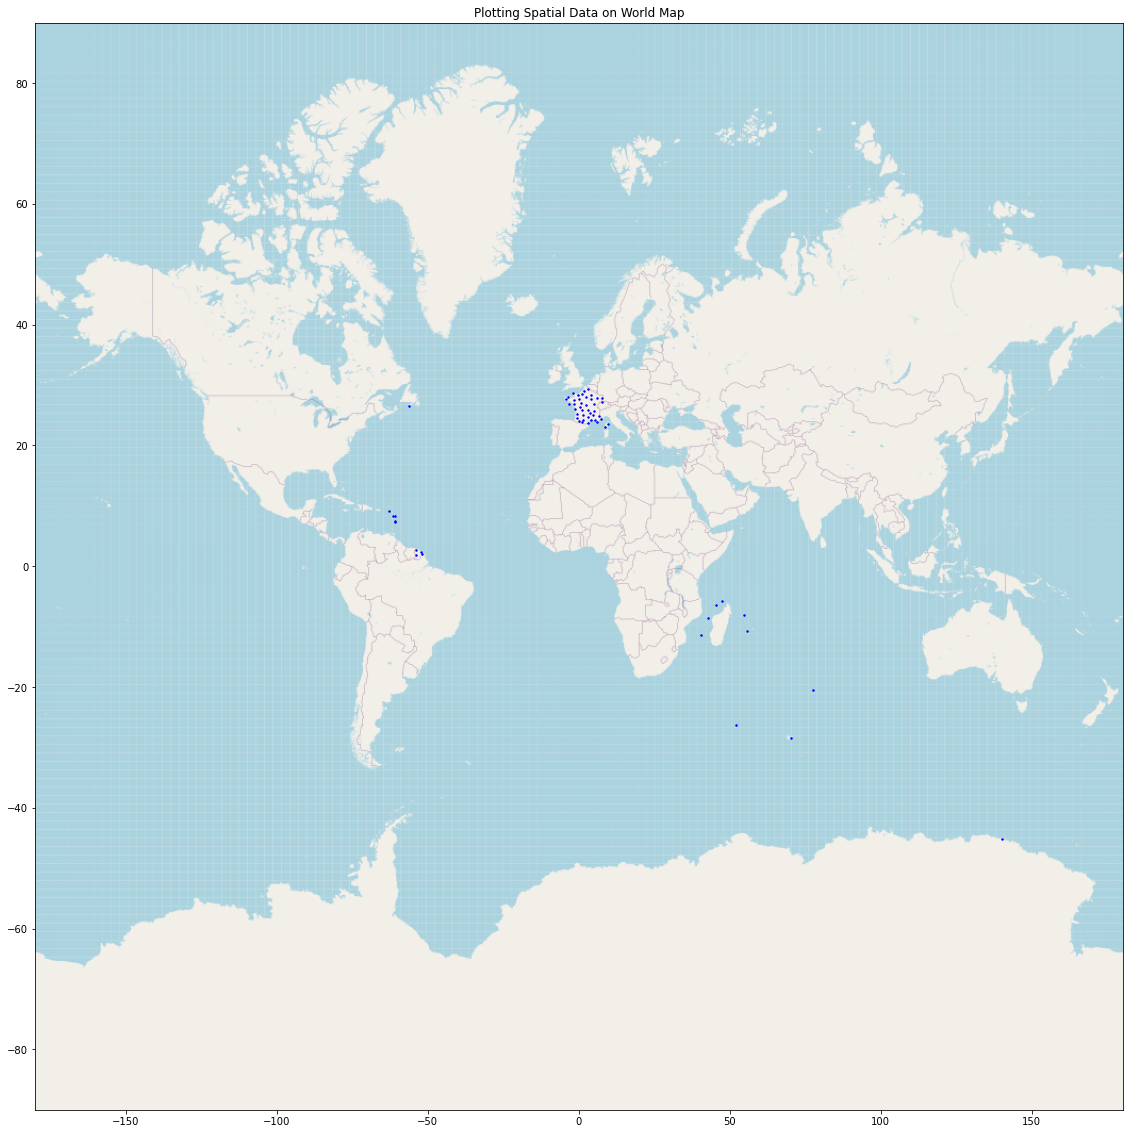

In [23]:
BBox = (-180, 180,
       -90, 90)

world = plt.imread('data/maps/world_map_backup.png')

fig, ax = plt.subplots(figsize = (20,20))
ax.scatter(df_stations.Longitude, 
           correct_coordinates(df_stations.Latitude),
           alpha=1, c='b', s=2)
ax.set_title('Plotting Spatial Data on World Map')
ax.set_xlim(BBox[0],BBox[1])
ax.set_ylim(BBox[2],BBox[3])
ax.imshow(world, extent=BBox, aspect=2)

<h1>Températures moyennes par heure (nord/sud/east/ouest) entre 1996 et 2020</h1>

Ici on requête à la volée pour mettre en avant la moyenne des temperatures heure par heure entre 1996 et 2020. On effectue 5 requetes une pour la france entière, une pour le Nord de la France, Une pour le Sud et enfin Est et Ouest. Ainsi avec le graphique ci-dessous on peut visualiser la différence selon l'heure et l'emplacement en France. 

In [24]:
#Requêtes pour les moyennes par heure et par moitié de France (Nord, Sud, Est, et Ouest)

driver = GraphDatabase.driver(uri, auth=(user, password))
session = driver.session()

result = session.run("MATCH (s:Station)<-[:A_ETE_RELEVE_A_STATION]-(r:Releve)-[:A_ETE_RELEVE_A_HEURE]->(h:Heure) "
                     "WHERE s.latitude >= 41 AND s.latitude <= 52 "
                     "AND s.longitude >= -5 AND s.longitude <= 10 "
                     "RETURN h.numero AS heure, "
                     "avg(r.temperature)-273.15 AS temperature_moyenne "
                     "ORDER BY heure")

temperature_moyenne_france = [record for record in result]

result = session.run("MATCH (s:Station)<-[:A_ETE_RELEVE_A_STATION]-(r:Releve)-[:A_ETE_RELEVE_A_HEURE]->(h:Heure) "
                     "WHERE s.latitude >= 47 AND s.latitude <= 52 "
                     "AND s.longitude >= -5 AND s.longitude <= 10 "
                     "RETURN h.numero AS heure, "
                     "avg(r.temperature)-273.15 AS temperature_moyenne "
                     "ORDER BY heure")

temperature_moyenne_nord = [record for record in result]

result = session.run("MATCH (s:Station)<-[:A_ETE_RELEVE_A_STATION]-(r:Releve)-[:A_ETE_RELEVE_A_HEURE]->(h:Heure) "
                     "WHERE s.latitude >= 41 AND s.latitude <= 47 "
                     "AND s.longitude >= -5 AND s.longitude <= 10 "
                     "RETURN h.numero AS heure, "
                     "avg(r.temperature)-273.15 AS temperature_moyenne "
                     "ORDER BY heure")

temperature_moyenne_sud = [record for record in result]

result = session.run("MATCH (s:Station)<-[:A_ETE_RELEVE_A_STATION]-(r:Releve)-[:A_ETE_RELEVE_A_HEURE]->(h:Heure) "
                     "WHERE s.latitude >= 41 AND s.latitude <= 52 "
                     "AND s.longitude >= -5 AND s.longitude <= 2.337 "
                     "RETURN h.numero AS heure, "
                     "avg(r.temperature)-273.15 AS temperature_moyenne "
                     "ORDER BY heure")

temperature_moyenne_ouest = [record for record in result]

result = session.run("MATCH (s:Station)<-[:A_ETE_RELEVE_A_STATION]-(r:Releve)-[:A_ETE_RELEVE_A_HEURE]->(h:Heure) "
                     "WHERE s.latitude >= 41 AND s.latitude <= 52 "
                     "AND s.longitude >= 2.337 AND s.longitude <= 10 "
                     "RETURN h.numero AS heure, "
                     "avg(r.temperature)-273.15 AS temperature_moyenne "
                     "ORDER BY heure")

temperature_moyenne_est = [record for record in result]

session.close()
driver.close()

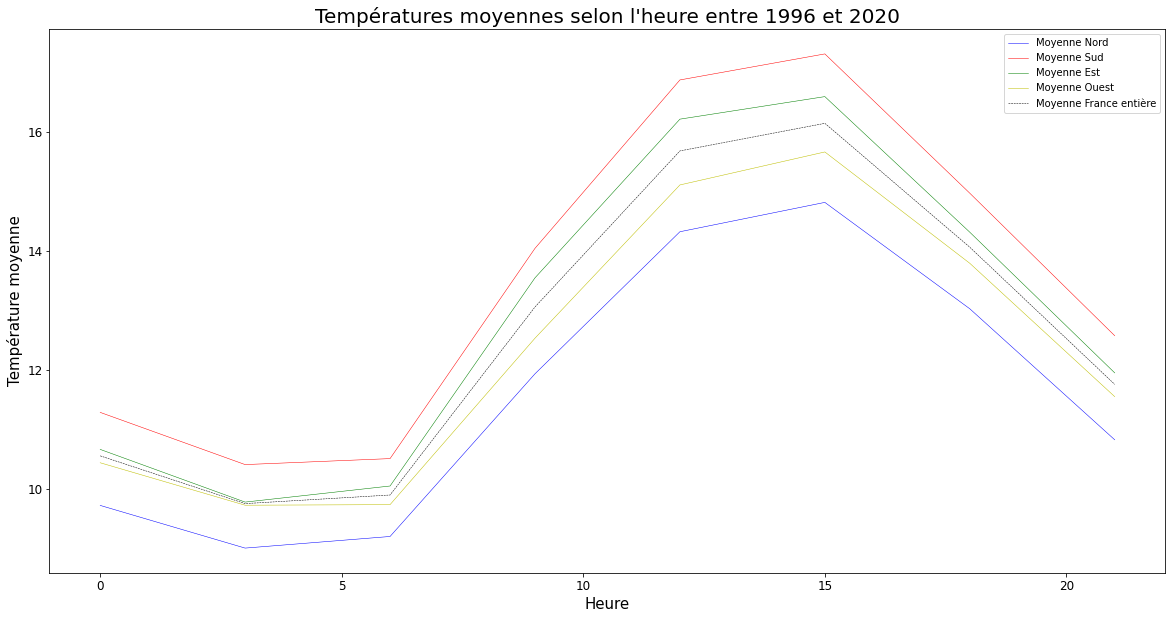

In [25]:
#Tracé des courbes exploitant les résultats précédents

heures = [record["heure"] for record in temperature_moyenne_france]

temperatures_france = [record["temperature_moyenne"] for record in temperature_moyenne_france]

temperatures_nord = [record["temperature_moyenne"] for record in temperature_moyenne_nord]

temperatures_sud = [record["temperature_moyenne"] for record in temperature_moyenne_sud]

temperatures_ouest = [record["temperature_moyenne"] for record in temperature_moyenne_ouest]

temperatures_est = [record["temperature_moyenne"] for record in temperature_moyenne_est]

fig, ax = plt.subplots(figsize=(20, 10))

ax.set_title("Températures moyennes selon l'heure entre 1996 et 2020", fontsize=20)

plt.plot(heures, temperatures_nord, "b", linewidth=0.5, label="Moyenne Nord")
plt.plot(heures, temperatures_sud, "r", linewidth=0.5, label="Moyenne Sud")
plt.plot(heures, temperatures_est, "g", linewidth=0.5, label="Moyenne Est")
plt.plot(heures, temperatures_ouest, "y", linewidth=0.5, label="Moyenne Ouest")
plt.plot(heures, temperatures_france, "k--", linewidth=0.5, label="Moyenne France entière")

plt.xlabel("Heure", fontsize=15)
plt.ylabel("Température moyenne", fontsize=15)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.legend()
plt.show()

## Température moyenne par année de 1996 à 2019 (Globale et France métropolitaine)

On voulait vérifier si le réchauffement climatique pourrait être visible sur nos données (sur 25ans). On requete ainsi la moyenne des temperature par année. Pour affiner le resultat nous proposons une approche global (sur toutes les stations Française) et une approche concentrée sur la France Métropolitaine. 

On effectue et trace ensuite pour chaque courbe une droite de regression linéaire afin de confimer ou non la tendance. Et malheureusement on se rend bien compte de l'évolution des températures en seulement 25ans ! 

On constate aussi la forte différence de climat entre les stations en France métropolitaine et celle ailleurs dans le monde. Elles rajoutent une différence de presque 2 degrés sur la moyenne.

In [26]:
driver = GraphDatabase.driver(uri, auth=(user, password))
session = driver.session()

result = session.run("MATCH (r:Releve)-[:A_ETE_RELEVE_A_ANNEE]->(a:Annee) "
                     "WHERE a.numero < 2020 "
                     "RETURN a.numero AS annee, avg(r.temperature)-273.15 AS temperature_moyenne "
                     "ORDER BY annee")

temperatures_moyennes = [record for record in result]

result = session.run("MATCH (s:Station)<-[:A_ETE_RELEVE_A_STATION]-(r:Releve)-[:A_ETE_RELEVE_A_ANNEE]->(a:Annee) "
                     "WHERE s.latitude >= 41 AND s.latitude <= 52 "
                     "AND s.longitude >= -5 AND s.longitude <= 10 "
                     "AND a.numero < 2020 "
                     "RETURN a.numero AS annee, avg(r.temperature)-273.15 AS temperature_moyenne "
                     "ORDER BY annee")

temperatures_moyennes_metropole = [record for record in result]

session.close()
driver.close()

C:\Users\geoff\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y, data. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\geoff\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y, data. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


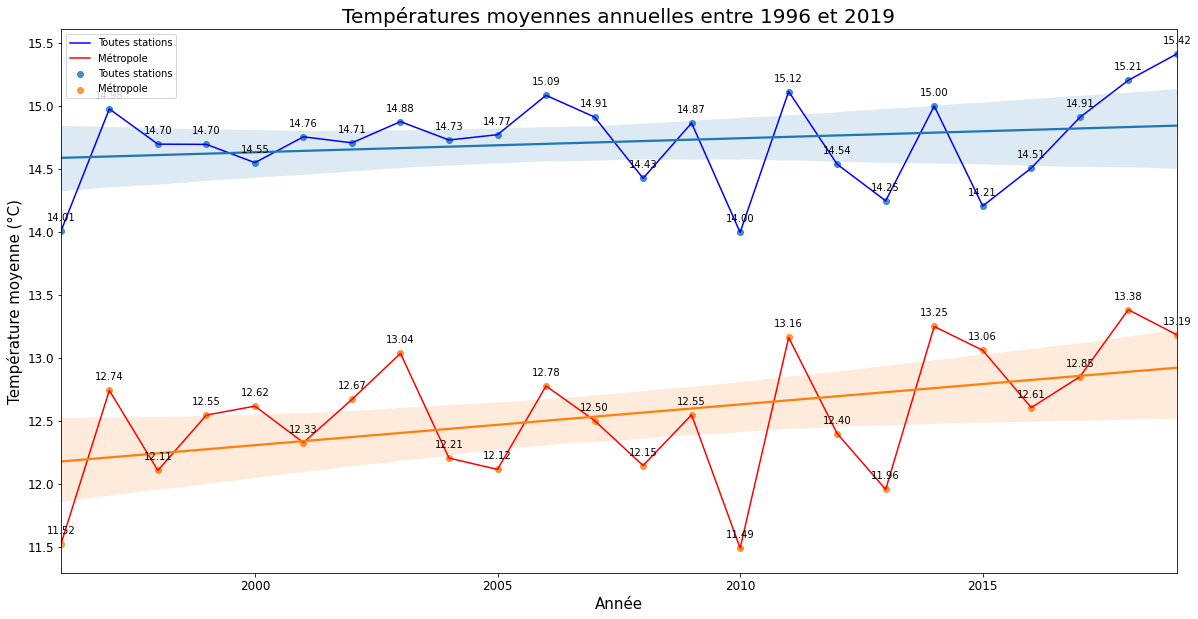

In [27]:
annees = [record["annee"] for record in temperatures_moyennes]

temperatures = [record["temperature_moyenne"] for record in temperatures_moyennes]

temperatures_metropole = [record["temperature_moyenne"] for record in temperatures_moyennes_metropole]

fig, ax = plt.subplots(figsize=(20, 10))

ax.set_title("Températures moyennes annuelles entre 1996 et 2019", fontsize=20)

plt.plot(annees, temperatures, "b", label="Toutes stations")
plt.plot(annees, temperatures_metropole, "r", label="Métropole")
sns.regplot(annees, temperatures, "r", label="Toutes stations")
sns.regplot(annees, temperatures_metropole, "b", label="Métropole")

plt.xlabel("Année", fontsize=15)
plt.ylabel("Température moyenne (°C)", fontsize=15)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

for x,y in zip(annees,temperatures):

    label = "{:.2f}".format(y)

    plt.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
for x,y in zip(annees,temperatures_metropole):

    label = "{:.2f}".format(y)

    plt.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center

plt.legend()
plt.show()

## Température moyenne par mois en France Métropolitaine depuis 25ans

Quelle est la température moyenne par mois depuis 25ans en France Metropolitaine ?
C'est avec une immense surprise que les mois de Juillet et Aout aparraissent comme les plus chauds. 
A contrario Decembre, Janvier, Février sont les plus froids de l'année.

In [28]:
driver = GraphDatabase.driver(uri, auth=(user, password))
session = driver.session()

result = session.run("MATCH (s:Station)<-[:A_ETE_RELEVE_A_STATION]-(r:Releve)-[:A_ETE_RELEVE_AU_MOIS]->(m:Mois) "
                     "WHERE s.latitude >= 41 AND s.latitude <= 52 "
                     "AND s.longitude >= -5 AND s.longitude <= 10 "
                     "RETURN m.numero AS mois, avg(r.temperature)-273.15 AS temperature_moyenne "
                     "ORDER BY mois")

temperatures_moyennes = [record for record in result]

session.close()
driver.close()

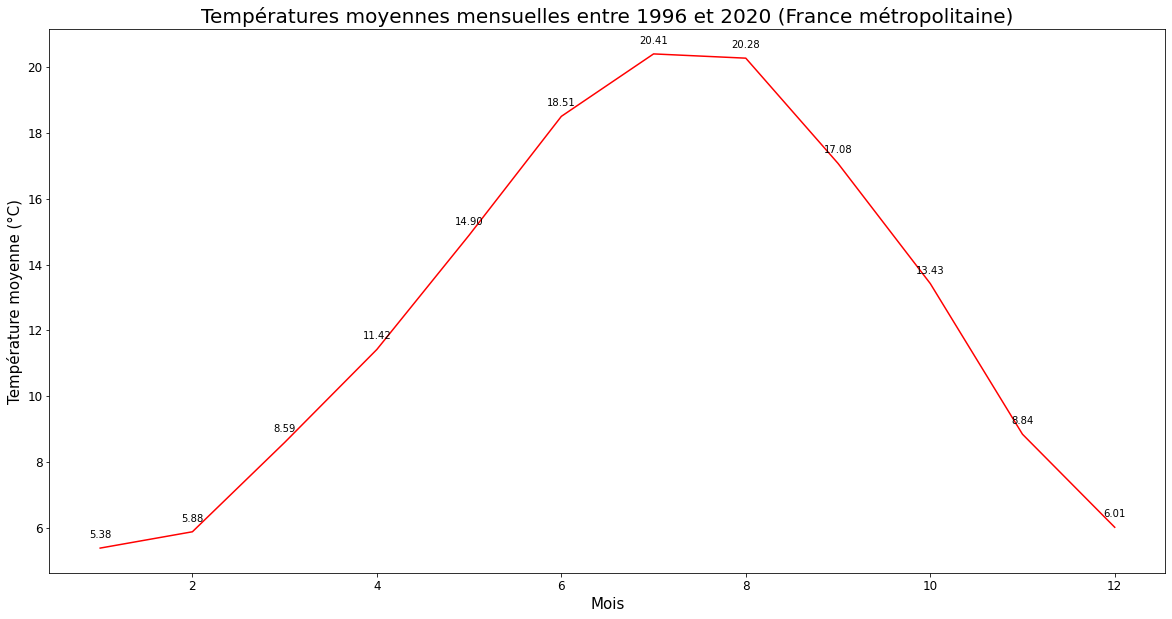

In [29]:
mois = [record["mois"] for record in temperatures_moyennes]

temperatures = [record["temperature_moyenne"] for record in temperatures_moyennes]

fig, ax = plt.subplots(figsize=(20, 10))

ax.set_title("Températures moyennes mensuelles entre 1996 et 2020 (France métropolitaine)", fontsize=20)

plt.plot(mois, temperatures, "r")

plt.xlabel("Mois", fontsize=15)
plt.ylabel("Température moyenne (°C)", fontsize=15)
#labels = [item.get_text() for item in ax.get_xticklabels()]
#print(labels)
#labels = ["Janvier", "Fevrier", "Mars", "Avril", "Mai", "Juin", "Juillet", "Aout", "Septembre", "Octobre", "Novembre", "Decembre"]

#ax.set_xticklabels(labels)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
for x,y in zip(mois,temperatures):

    label = "{:.2f}".format(y)

    plt.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
plt.show()

## Moyenne par station

Ici on peut voir les températures moyennes par station. On peut voir que la seule station avec une moyenne négative est la Base Antarctique Dumont D'Urville

In [30]:
driver = GraphDatabase.driver(uri, auth=(user, password))
session = driver.session()

result = session.run("MATCH (s:Station)<-[:A_ETE_RELEVE_A_STATION]-(r:Releve) "
                     "RETURN s.nom AS station, avg(r.temperature)-273.15 AS temperature_moyenne "
                     "ORDER BY temperature_moyenne")

temperatures_moyennes = [record for record in result]

session.close()
driver.close()

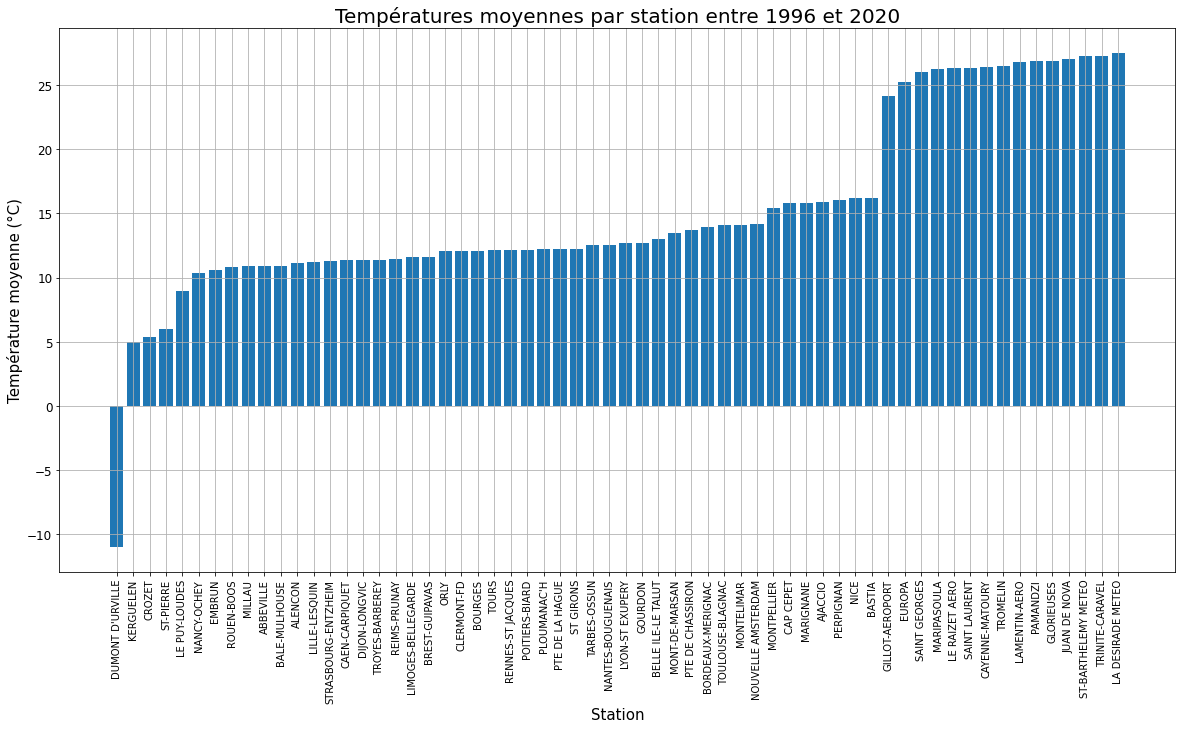

In [31]:
stations = [record["station"] for record in temperatures_moyennes]

temperatures = [record["temperature_moyenne"] for record in temperatures_moyennes]

fig, ax = plt.subplots(figsize=(20, 10))

ax.set_title("Températures moyennes par station entre 1996 et 2020", fontsize=20)

ax.bar(stations, temperatures)

plt.xlabel("Station", fontsize=15)
plt.ylabel("Température moyenne (°C)", fontsize=15)

plt.xticks(fontsize=10,rotation=90)
plt.yticks(fontsize=12)

plt.grid()
plt.show()

Les stations avec une moyenne de plus de 20°C

In [32]:
driver = GraphDatabase.driver(uri, auth=(user, password))
session = driver.session()

result = session.run("MATCH (s:Station)<-[:A_ETE_RELEVE_A_STATION]-(r:Releve) "
                     "WITH avg(r.temperature)-273.15 AS temperature_moyenne, s "
                     "WHERE temperature_moyenne >= 20 "
                     "RETURN s.nom AS station, temperature_moyenne "
                     "ORDER BY temperature_moyenne")

temperatures_moyennes = [record for record in result]

session.close()
driver.close()

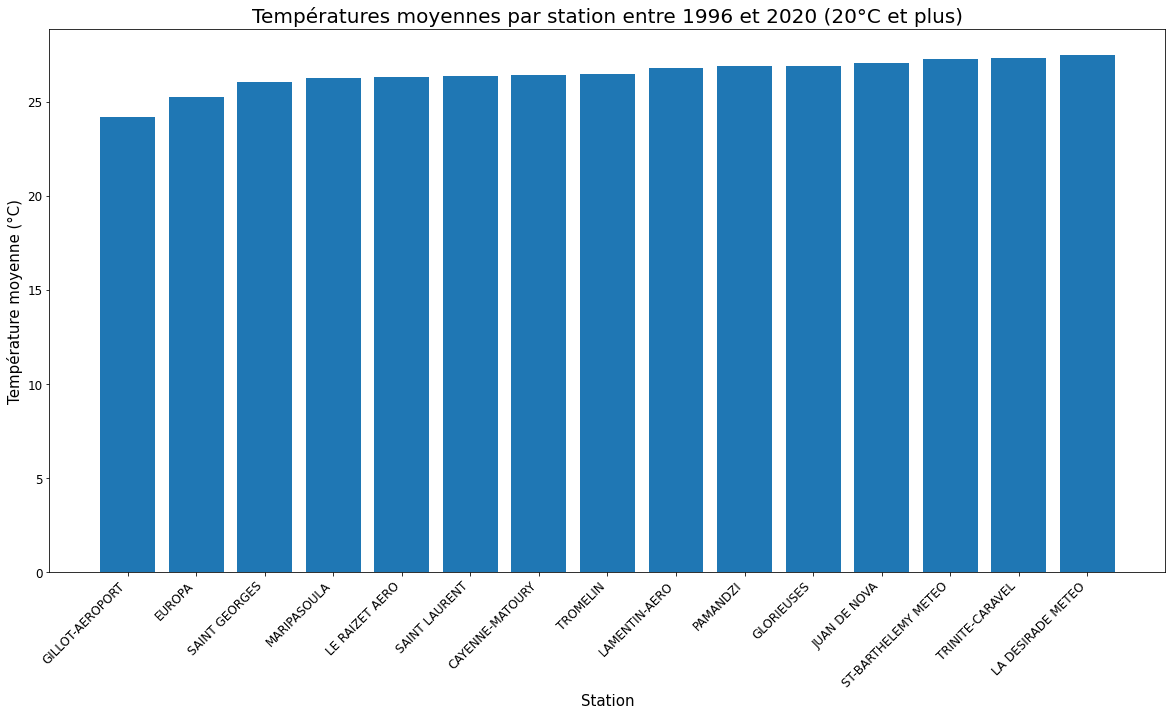

In [33]:
stations = [record["station"] for record in temperatures_moyennes]

temperatures = [record["temperature_moyenne"] for record in temperatures_moyennes]

fig, ax = plt.subplots(figsize=(20, 10))

ax.set_title("Températures moyennes par station entre 1996 et 2020 (20°C et plus)", fontsize=20)

ax.bar(stations, temperatures)

plt.xlabel("Station", fontsize=15)
plt.ylabel("Température moyenne (°C)", fontsize=15)

plt.xticks(fontsize=12, rotation=45, ha="right")
plt.yticks(fontsize=12)

plt.show()

Les stations avec une moyenne de moins de 10°C

In [34]:
driver = GraphDatabase.driver(uri, auth=(user, password))
session = driver.session()

result = session.run("MATCH (s:Station)<-[:A_ETE_RELEVE_A_STATION]-(r:Releve) "
                     "WITH avg(r.temperature)-273.15 AS temperature_moyenne, s "
                     "WHERE temperature_moyenne <= 10 "
                     "RETURN s.nom AS station, temperature_moyenne "
                     "ORDER BY temperature_moyenne")

temperatures_moyennes = [record for record in result]

session.close()
driver.close()

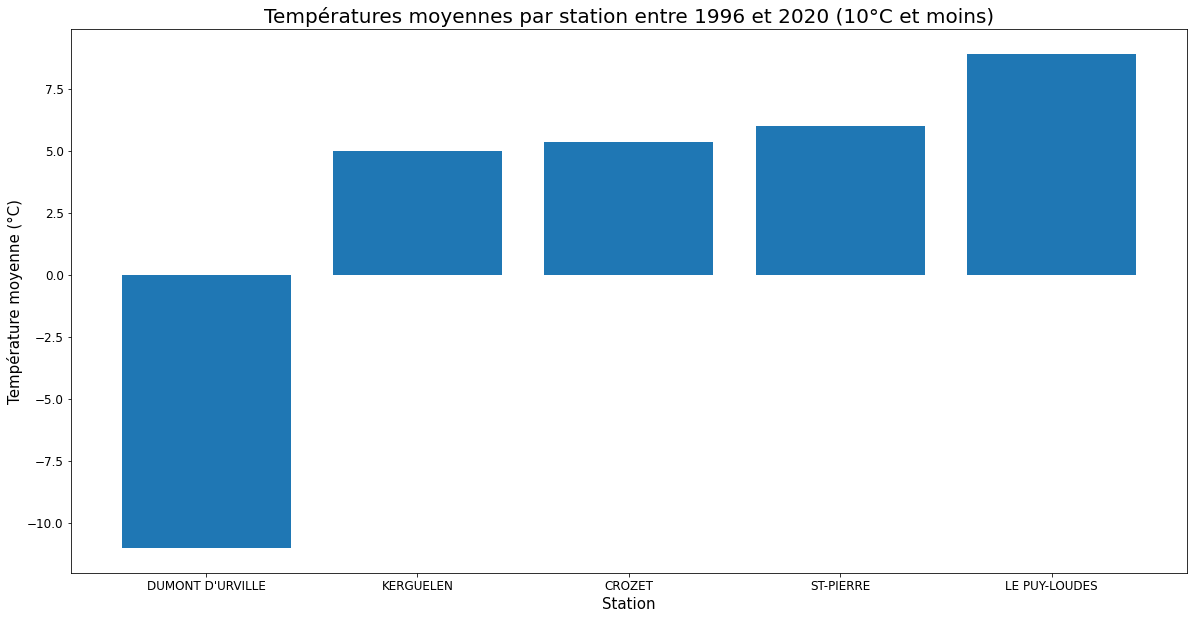

In [35]:
stations = [record["station"] for record in temperatures_moyennes]

temperatures = [record["temperature_moyenne"] for record in temperatures_moyennes]

fig, ax = plt.subplots(figsize=(20, 10))

ax.set_title("Températures moyennes par station entre 1996 et 2020 (10°C et moins)", fontsize=20)

ax.bar(stations, temperatures)

plt.xlabel("Station", fontsize=15)
plt.ylabel("Température moyenne (°C)", fontsize=15)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.show()

## Evolution des températures minimales et maximales par année

Toujours avec le soucis de mettre en lumière le rechauffement climatique via ces données. On peut néanmoins voir que les maximales et minimales de température ont peu/pas évolué. Peut on en déduire que le réchauffement climatique n'affecte pas les valeurs extremes mais plus une augmentation des valeurs moyennes ? 

In [36]:
driver = GraphDatabase.driver(uri, auth=(user, password))
session = driver.session()

result = session.run("MATCH (r:Releve)-[:A_ETE_RELEVE_A_ANNEE]->(a:Annee) "
                     "WHERE a.numero < 2020 "
                     "RETURN a.numero AS annee, min(r.temperature)-273.15 AS temperature_min "
                     "ORDER BY annee")

temperatures_min = [record for record in result]

result = session.run("MATCH (r:Releve)-[:A_ETE_RELEVE_A_ANNEE]->(a:Annee) "
                     "WHERE a.numero < 2020 "
                     "RETURN a.numero AS annee, max(r.temperature)-273.15 AS temperature_max "
                     "ORDER BY annee")

temperatures_max = [record for record in result]

session.close()
driver.close()

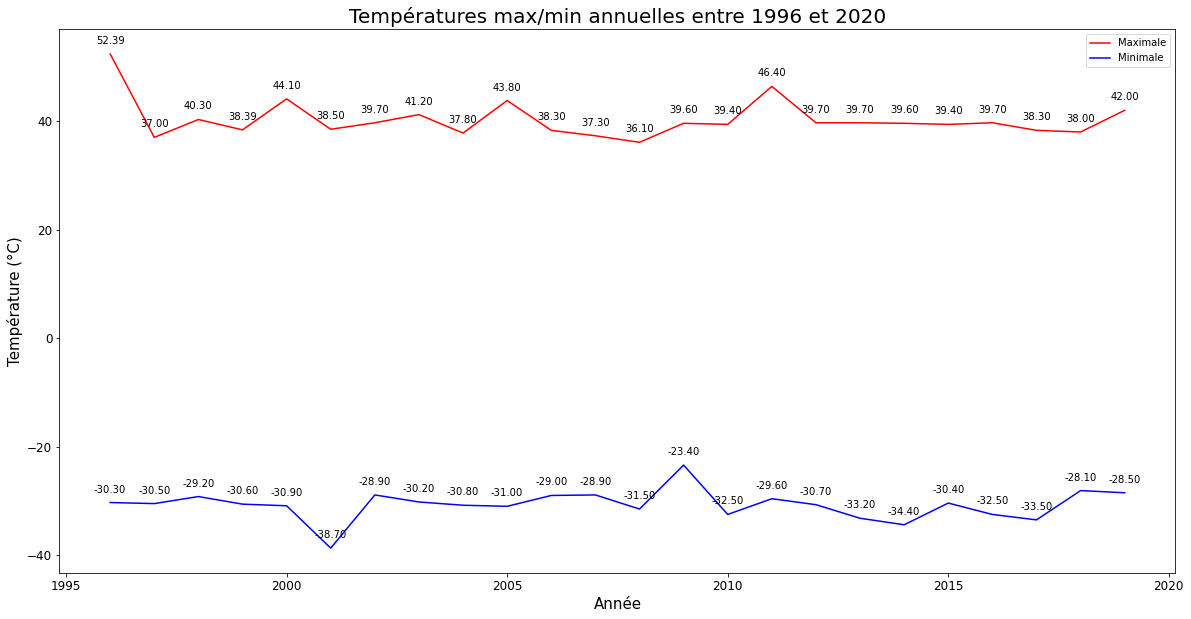

In [37]:
annees = [record["annee"] for record in temperatures_min]

temperatures_max = [record["temperature_max"] for record in temperatures_max]

temperatures_min = [record["temperature_min"] for record in temperatures_min]

fig, ax = plt.subplots(figsize=(20, 10))

ax.set_title("Températures max/min annuelles entre 1996 et 2020", fontsize=20)

plt.plot(annees, temperatures_max, "r", label="Maximale")
plt.plot(annees, temperatures_min, "b", label="Minimale")

plt.xlabel("Année", fontsize=15)
plt.ylabel("Température (°C)", fontsize=15)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
for x,y in zip(annees,temperatures_max):

    label = "{:.2f}".format(y)

    plt.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
for x,y in zip(annees,temperatures_min):

    label = "{:.2f}".format(y)

    plt.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center

plt.legend()
plt.show()

## Ecart à la normale des années 1996-2009 pendant l'été sur les année 2010-2020

Ici on veut comparer les températures des années 2010-2020 par rappord à la normale des températures. 
On entend souvent à la météo: "Aujourd'hui il fait 3 degrés celsius de plus comparé à la normale des températures en cette période"
Cela signifie que la température du jour est 3 degrés plus élevée que la moyenne des températures de ce jour sur les 5 dernières années par exemple.

On va donc calculer la normale de température (moyenne) entre 1996 et 2009. Et montrer les ecarts par rapport à cette moyenne pour les températures de 2010 à 2020. 

In [38]:
driver = GraphDatabase.driver(uri, auth=(user, password))
session = driver.session()

result = session.run("MATCH (s:Station)<-[:A_ETE_RELEVE_A_STATION]-(r:Releve)-[:A_ETE_RELEVE_AU_MOIS]->(m:Mois) "
                     "MATCH (r)-[:A_ETE_RELEVE_A_ANNEE]->(a:Annee) "
                     "WHERE 7 <= m.numero <= 9 "
                     "AND s.latitude >= 41 AND s.latitude <= 52 "
                     "AND s.longitude >= -5 AND s.longitude <= 10 "
                     "AND 1996 <= a.numero <= 2009 "
                     "MATCH (s)<-[:A_ETE_RELEVE_A_STATION]-(r2:Releve)-[:A_ETE_RELEVE_AU_MOIS]->(m) "
                     "MATCH (r2)-[:A_ETE_RELEVE_A_ANNEE]->(a2:Annee) "
                     "WHERE 2010 <= a2.numero <= 2020 "
                     "RETURN a2.numero AS annee, avg(r2.temperature)-avg(r.temperature) AS ecart")

ecarts_moyens = [record for record in result]

session.close()
driver.close()

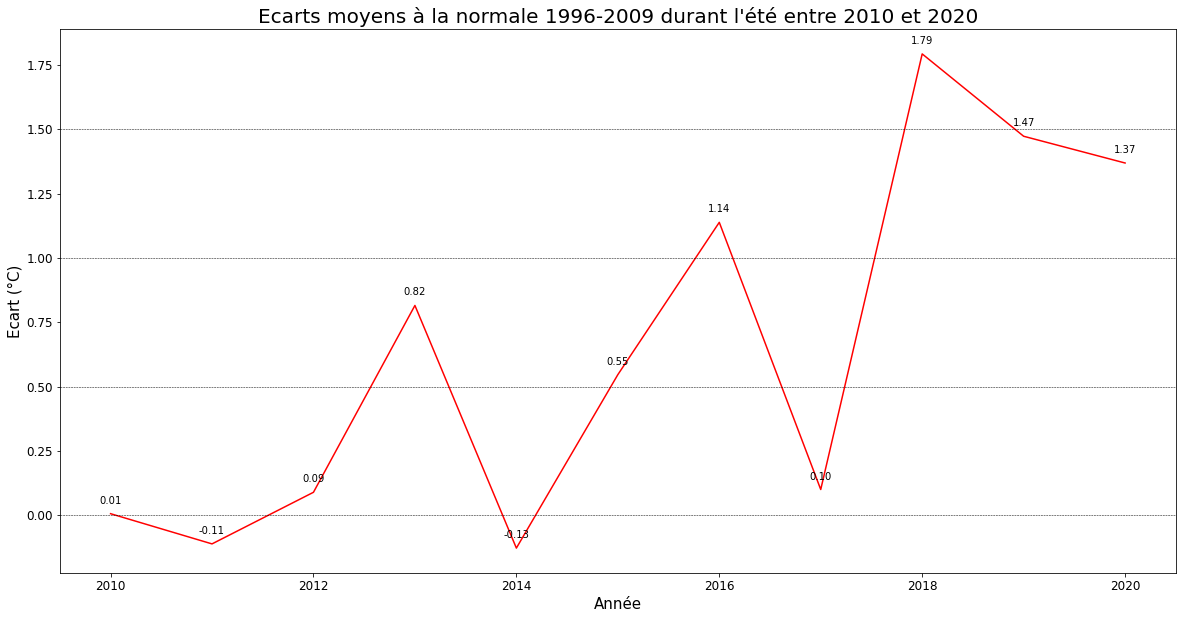

In [39]:
annees = [record["annee"] for record in ecarts_moyens]

ecarts = [record["ecart"] for record in ecarts_moyens]

fig, ax = plt.subplots(figsize=(20, 10))

ax.set_title("Ecarts moyens à la normale 1996-2009 durant l'été entre 2010 et 2020", fontsize=20)

plt.plot(annees, ecarts, "r")

plt.xlabel("Année", fontsize=15)
plt.ylabel("Ecart (°C)", fontsize=15)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.axhline(y=0, color='k', linestyle='--', linewidth=0.5)
plt.axhline(y=0.5, color='k', linestyle='--', linewidth=0.5)
plt.axhline(y=1, color='k', linestyle='--', linewidth=0.5)
plt.axhline(y=1.5, color='k', linestyle='--', linewidth=0.5)
for x,y in zip(annees,ecarts):

    label = "{:.2f}".format(y)

    plt.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center

plt.show()

## Ensoleillement moyen entre 1996 et 2020 par station

Ici on souhaite montrer l'ensoleillement moyen en pourcentage par saison et par station. Ainsi on peut mettre en avant le manque d'ensoleillement selon la saison dans certaines régions. 

In [40]:
driver = GraphDatabase.driver(uri, auth=(user, password))
session = driver.session()

result = session.run("MATCH (s:Station)<-[:A_ETE_RELEVE_A_STATION]-(r:Releve)-[:A_ETE_RELEVE_A_HEURE]->(h:Heure) "
                     "MATCH (a:Annee)<-[:A_ETE_RELEVE_A_ANNEE]-(r)-[:A_ETE_RELEVE_AU_MOIS]->(m:Mois) "
                     "WHERE s.latitude >= 41 AND s.latitude <= 52 "
                     "AND s.longitude >= -5 AND s.longitude <= 10 "
                     "AND r.nebulosite IS NOT NULL "
                     "RETURN s.nom AS station, "
                     "CASE "
                     "    WHEN 1 <= m.numero <= 3 THEN 'Hiver' "
                     "    WHEN 4 <= m.numero <= 6 THEN 'Printemps' "
                     "    WHEN 7 <= m.numero <= 9 THEN 'Eté' "
                     "    WHEN 10 <= m.numero <= 12 THEN 'Automne' "
                     "END AS saison, "
                     "100.0*sum(CASE "
                     "    WHEN r.nebulosite < 5 THEN "
                     "    CASE "
                     "        WHEN m.numero = 1 AND 9 <= h.numero <= 17 THEN 1 "
                     "        WHEN m.numero = 2 AND 8 <= h.numero <= 18 THEN 1 "
                     "        WHEN m.numero = 3 AND 7 <= h.numero <= 19 THEN 1 "
                     "        WHEN m.numero = 4 AND 7 <= h.numero <= 20 THEN 1 "
                     "        WHEN m.numero = 5 AND 6 <= h.numero <= 21 THEN 1 "
                     "        WHEN m.numero = 6 AND 6 <= h.numero <= 22 THEN 1 "
                     "        WHEN m.numero = 7 AND 6 <= h.numero <= 22 THEN 1 "
                     "        WHEN m.numero = 8 AND 7 <= h.numero <= 21 THEN 1 "
                     "        WHEN m.numero = 9 AND 7 <= h.numero <= 20 THEN 1 "
                     "        WHEN m.numero = 10 AND 8 <= h.numero <= 18 THEN 1 "
                     "        WHEN m.numero = 11 AND 8 <= h.numero <= 17 THEN 1 "
                     "        WHEN m.numero = 12 AND 8 <= h.numero <= 17 THEN 1 "
                     "        ELSE 0 "
                     "    END "
                     "    ELSE 0 "
                     "END)/count(r) AS ensoleillement "
                     "ORDER BY ensoleillement DESC")

ensoleillement_moyens = [record for record in result]

session.close()
driver.close()

## Automne

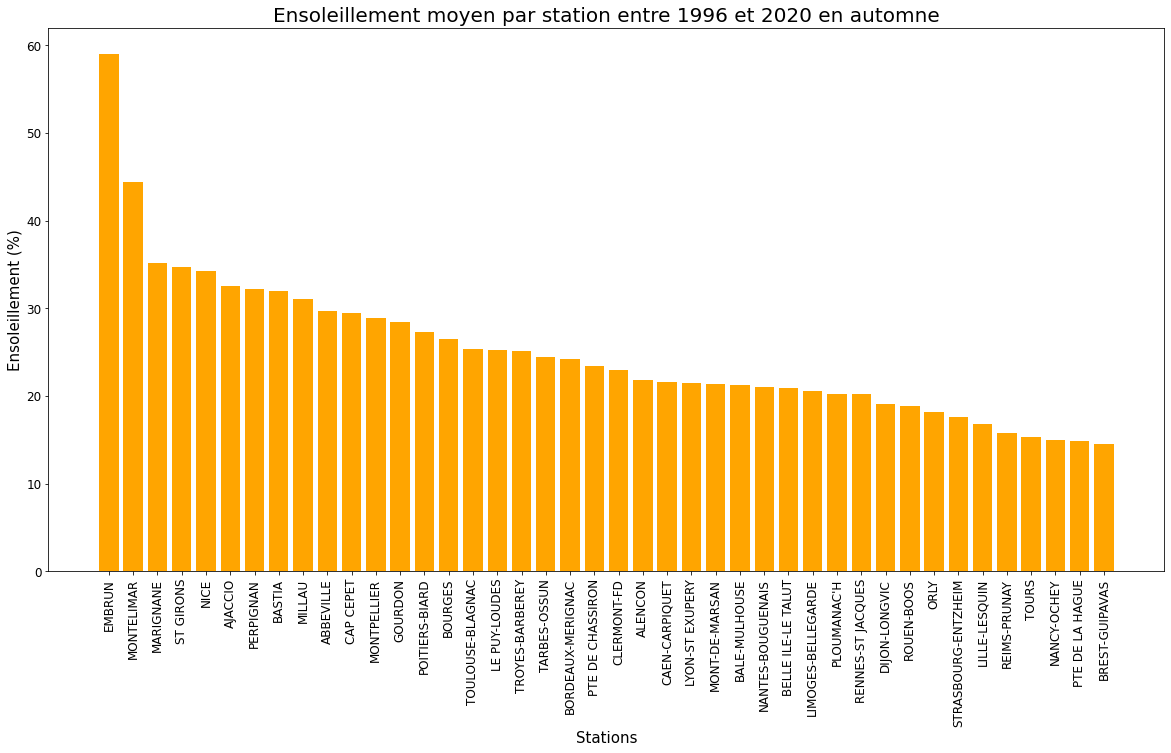

In [42]:
stations_automne = [record["station"] for record in ensoleillement_moyens if record["saison"] == "Automne"]

ensoleillements_automne = [record["ensoleillement"] for record in ensoleillement_moyens if record["saison"] == "Automne"]

fig, ax = plt.subplots(figsize=(20, 10))

ax.set_title("Ensoleillement moyen par station entre 1996 et 2020 en automne", fontsize=20)

ax.bar(stations_automne, ensoleillements_automne, color="orange")

plt.xlabel("Stations", fontsize=15)
plt.ylabel("Ensoleillement (%)", fontsize=15)

plt.xticks(fontsize=12, rotation=90)
plt.yticks(fontsize=12)

plt.show()

## Hiver

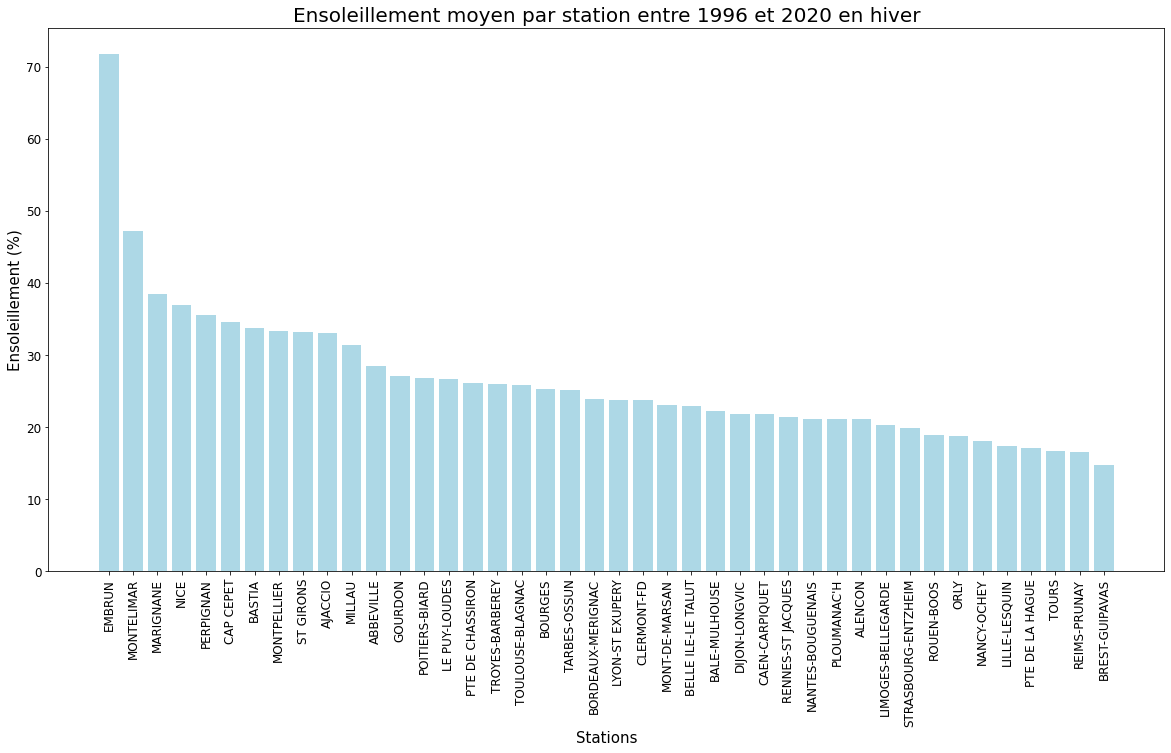

In [43]:
stations_hiver = [record["station"] for record in ensoleillement_moyens if record["saison"] == "Hiver"]

ensoleillements_hiver = [record["ensoleillement"] for record in ensoleillement_moyens if record["saison"] == "Hiver"]

fig, ax = plt.subplots(figsize=(20, 10))

ax.set_title("Ensoleillement moyen par station entre 1996 et 2020 en hiver", fontsize=20)

ax.bar(stations_hiver, ensoleillements_hiver, color="lightblue")

plt.xlabel("Stations", fontsize=15)
plt.ylabel("Ensoleillement (%)", fontsize=15)

plt.xticks(fontsize=12, rotation=90)
plt.yticks(fontsize=12)

plt.show()

## Printemps

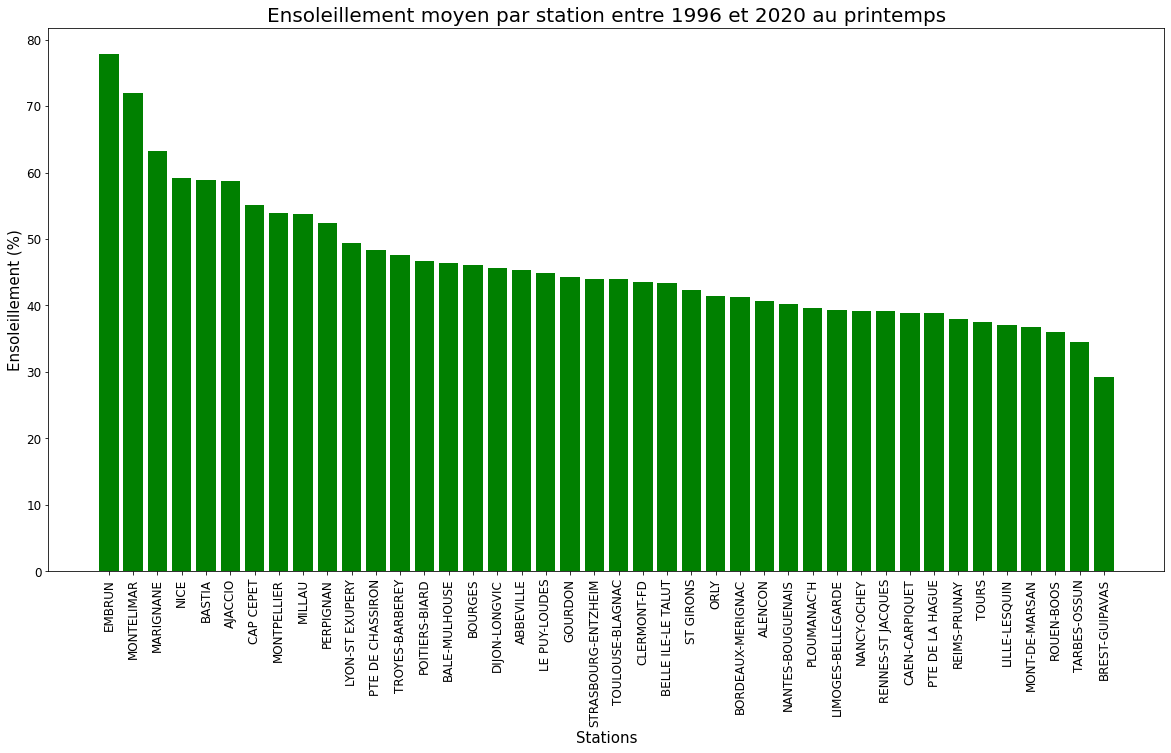

In [44]:
stations_printemps = [record["station"] for record in ensoleillement_moyens if record["saison"] == "Printemps"]

ensoleillements_printemps = [record["ensoleillement"] for record in ensoleillement_moyens if record["saison"] == "Printemps"]

fig, ax = plt.subplots(figsize=(20, 10))

ax.set_title("Ensoleillement moyen par station entre 1996 et 2020 au printemps", fontsize=20)

ax.bar(stations_printemps, ensoleillements_printemps, color="green")

plt.xlabel("Stations", fontsize=15)
plt.ylabel("Ensoleillement (%)", fontsize=15)

plt.xticks(fontsize=12, rotation=90)
plt.yticks(fontsize=12)

plt.show()

## Ete

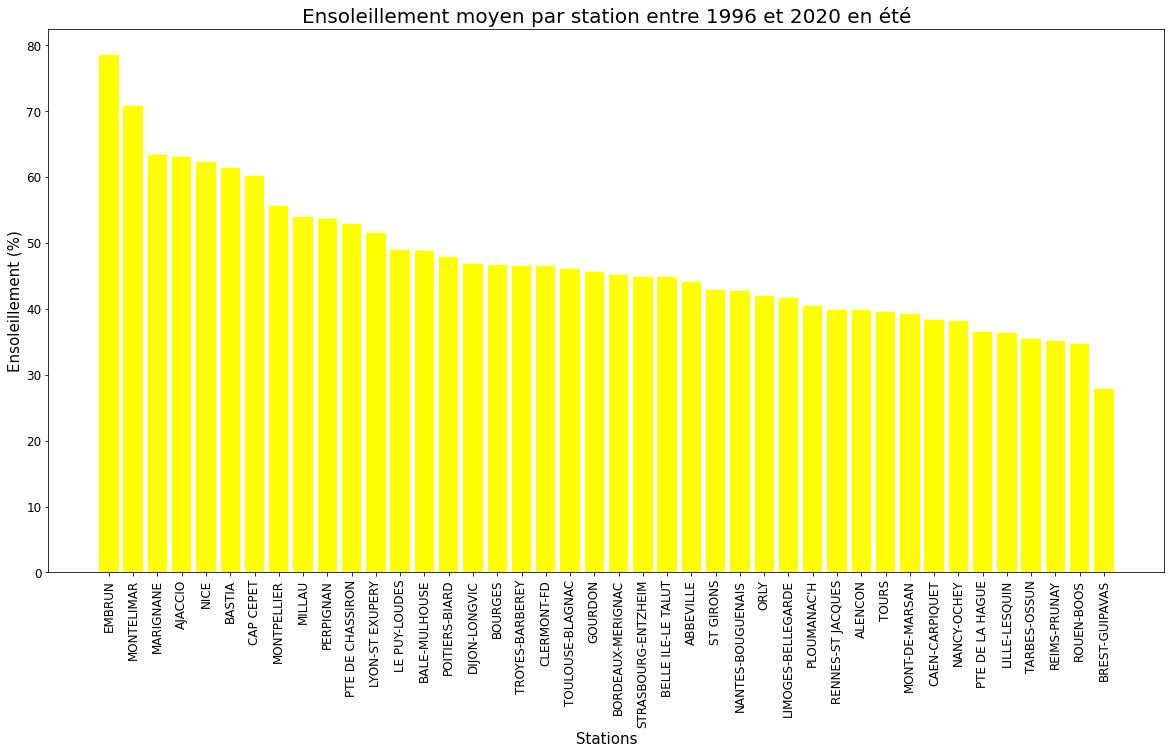

In [45]:
stations_ete = [record["station"] for record in ensoleillement_moyens if record["saison"] == "Eté"]

ensoleillements_ete = [record["ensoleillement"] for record in ensoleillement_moyens if record["saison"] == "Eté"]

fig, ax = plt.subplots(figsize=(20, 10))

ax.set_title("Ensoleillement moyen par station entre 1996 et 2020 en été", fontsize=20)

ax.bar(stations_ete, ensoleillements_ete, color="yellow")

plt.xlabel("Stations", fontsize=15)
plt.ylabel("Ensoleillement (%)", fontsize=15)

plt.xticks(fontsize=12, rotation=90)
plt.yticks(fontsize=12)

plt.show()